In [53]:
# Cell 0: Init library imports and repo path setup
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

# add repo root (parent of notebooks/) to sys.path (use resolve for robustness)
repo_root = str(Path.cwd().resolve().parent)
if repo_root not in sys.path:
    sys.path.append(repo_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# Cell 1: imports & basic config
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit_aer import AerSimulator
from pathlib import Path
from tqdm import trange
import json
from lib.graphlib import GraphLib

# Notebook defaults
AER_BACKEND = AerSimulator()
QAOA_SHOTS = 512  # simulator shots for validating angles
EDGE_PROB = 0.3
WEIGHT_RANGE = (1, 10)
REPEATS = 5  # Repeats per size
PARTIAL_RESULT_PATH = Path(
    repo_root + "/data/maxcut_qaoa_partial_results.jsonl")

# Sweep sizes (you can change / expand)
MAX_SIZE_FOR_OPT = 19  # max n for which we compute optimal cuts via brute-force
MAX_SIZE_FOR_AER = 28  # max n for which we run the simulator (AER)
SIZE_RANGE = list(range(2, 50, 1))

# For plotting aesthetics
sns.set_theme(context="talk", style="whitegrid")

In [55]:
# Cell 2: helper to run one graph instance and return results as dict
def run_single_instance(n, edge_prob=EDGE_PROB, weight_range=WEIGHT_RANGE, shots=QAOA_SHOTS):
    """
    Generate a random graph with n nodes and run:
      - classical approximations (random, local search)
      - qaoa p=1 analytic optimize + simulated validation (shots)
      - optional brute-force exact optimum if compute_optimal True
    Returns a dict with values and timings.
    """
    g = GraphLib()
    g.generate_random_graph(
        num_vertices=n, edge_prob=edge_prob, weight_range=weight_range)

    out = {'n': n}
    # Classical random approx
    t0 = time.time()
    _, w_rand = g.max_cut_random(trials=2000)
    t_rand = time.time() - t0
    out.update({'rand_cut': w_rand, 'rand_time': t_rand})

    # Classical local search approx
    t0 = time.time()
    _, w_local = g.max_cut_local_search(iterations=200)
    t_local = time.time() - t0
    out.update({'local_cut': w_local, 'local_time': t_local})

    # Brute force optimal if allowed for small n
    if n <= MAX_SIZE_FOR_OPT:
        t0 = time.time()
        _, w_opt = g.max_cut_bruteforce()
        t_opt = time.time() - t0
        out.update({'opt_cut': w_opt, 'opt_time': t_opt})
    else:
        out.update({'opt_cut': None, 'opt_time': None})

    if (n <= MAX_SIZE_FOR_AER):
        # Simulator backend feasible only for small n
        # QAOA p=1: analytic optimization (fast)
        t0 = time.time()
        gamma_star, beta_star, val_star, _ = g.optimize_qaoa1_classical(
            grid_res=41, refine=True)
        t_qaoa_opt = time.time() - t0
        out.update({'qaoa_gamma': gamma_star, 'qaoa_beta': beta_star,
                    'qaoa_analytic_val': val_star, 'qaoa_opt_time': t_qaoa_opt})

        # Validate via simulator (shots)
        t0 = time.time()
        res = g.qaoa1_expectation_simulated(
            gamma_star, beta_star, shots=shots, backend=AER_BACKEND)
        t_qaoa_sim = time.time() - t0
        # res includes 'expectation' (sampled average), 'best_cut' (best sample)
        out.update({
            'qaoa_sampled_expectation': res['expectation'],
            'qaoa_best_cut': res['best_cut'],
            'qaoa_counts': res['counts'],
            'qaoa_sim_time': t_qaoa_sim,
            'qaoa_total_time': t_qaoa_sim + t_qaoa_opt,
            'qaoa_shots': shots
        })
    else:
        out.update({
            'qaoa_gamma': None, 'qaoa_beta': None,
            'qaoa_analytic_val': None, 'qaoa_opt_time': None,
            'qaoa_sampled_expectation': None, 'qaoa_best_cut': None,
            'qaoa_counts': None, 'qaoa_sim_time': None,
            'qaoa_total_time': None,
            'qaoa_shots': None
        })
    return out

In [56]:
# Cell 3: Remove previous partial-results file so a full top-to-bottom run starts fresh
PARTIAL_RESULT_PATH.parent.mkdir(parents=True, exist_ok=True)
if PARTIAL_RESULT_PATH.exists():
    PARTIAL_RESULT_PATH.unlink()
    print(f"Removed existing partial results: {PARTIAL_RESULT_PATH}")
else:
    print(f"No partial results to remove at: {PARTIAL_RESULT_PATH}")

Removed existing partial results: C:\dev\qc-hello-worlds\data\maxcut_qaoa_partial_results.jsonl


In [57]:
# Cell 4: sweep driver that runs multiple repeats per n and collects results
def sweep_ns(ns_list, repeats=REPEATS, partial_result_path=PARTIAL_RESULT_PATH):
    rows = []
    # Single outer progress bar over graph sizes; update its description to show current size & repeat
    outer = trange(len(ns_list), desc="n=")
    for idx in outer:
        n = ns_list[idx]
        for r in range(repeats):
            try:
                # Update outer progress bar description to show current graph size and repeat number
                outer.set_description(f"n={n} r={r+1}/{repeats}")
                row = run_single_instance(
                    n, edge_prob=EDGE_PROB, weight_range=WEIGHT_RANGE, shots=QAOA_SHOTS)
                row['repeat'] = r
                rows.append(row)
                # append to disk incrementally
                with partial_result_path.open("a") as f:
                    f.write(json.dumps(row, default=str) + "\n")
            except Exception as e:
                print(f"Instance failed for n={n}, repeat={r}: {e}")
    df = pd.DataFrame(rows)
    return df


# Run the sweep (this will take time depending on NS_ALL and repeats)
df = sweep_ns(SIZE_RANGE)
df.head()

n=49 r=5/5: 100%|██████████| 48/48 [57:32<00:00, 71.92s/it]   



,n,rand_cut,rand_time,local_cut,local_time,opt_cut,opt_time,qaoa_gamma,qaoa_beta,qaoa_analytic_val,qaoa_opt_time,qaoa_sampled_expectation,qaoa_best_cut,qaoa_counts,qaoa_sim_time,qaoa_total_time,qaoa_shots,repeat
0,2,0,0.151019,0,0.000158,0.0,0.000238,1.000000,0.000000,0.0,0.114510,0.000000,0.0,"{'10': 120, '01': 122, '00': 118, '11': 152}",1.531250,1.645760,512.0,0
1,2,3,0.249181,3,0.000114,3.0,0.000192,1.570796,0.392699,3.0,0.595232,1.511719,3.0,"{'11': 125, '00': 129, '10': 121, '01': 137}",0.713547,1.308779,512.0,1
2,2,4,0.141249,4,0.000085,4.0,0.000140,1.570796,0.392699,4.0,0.156802,2.117188,4.0,"{'11': 113, '00': 128, '10': 123, '01': 148}",0.578639,0.735440,512.0,2
3,2,4,0.138815,4,0.000131,4.0,0.000222,1.570796,0.392699,4.0,0.149177,1.906250,4.0,"{'01': 112, '11': 145, '10': 132, '00': 123}",0.663825,0.813003,512.0,3
4,2,0,0.151831,0,0.000118,0.0,0.000261,1.000000,0.000000,0.0,0.047118,0.000000,0.0,"{'01': 129, '00': 115, '10': 133, '11': 135}",0.554644,0.601761,512.0,4


In [58]:
# Cell 5: compute aggregated metrics per n and algorithm; compute aggregates
def compute_aggregates(df):
    # Ensure we have a count per group
    counts = df.groupby("n").size().rename("count").reset_index()
    # Use named aggregations for clarity
    agg = df.groupby("n").agg(
        opt_cut_mean=("opt_cut", "mean"),
        opt_cut_std=("opt_cut", "std"),
        rand_cut_mean=("rand_cut", "mean"),
        rand_cut_std=("rand_cut", "std"),
        local_cut_mean=("local_cut", "mean"),
        local_cut_std=("local_cut", "std"),
        qaoa_best_cut_mean=("qaoa_best_cut", "mean"),
        qaoa_best_cut_std=("qaoa_best_cut", "std"),
        rand_time_mean=("rand_time", "mean"),
        rand_time_std=("rand_time", "std"),
        local_time_mean=("local_time", "mean"),
        local_time_std=("local_time", "std"),
        qaoa_total_time_mean=("qaoa_total_time", "mean"),
        qaoa_total_time_std=("qaoa_total_time", "std"),
        opt_time_mean=("opt_time", "mean"),
        opt_time_std=("opt_time", "std"),
    ).reset_index()

    # attach counts and compute SEM using per-group counts
    agg = agg.merge(counts, on="n", how="left")

    for col_prefix in [
        "opt_cut",
        "rand_cut",
        "local_cut",
        "qaoa_best_cut",
        "rand_time",
        "local_time",
        "qaoa_total_time",
        "opt_time",
    ]:
        std_col = f"{col_prefix}_std"
        sem_col = f"{col_prefix}_sem"
        # treat NaN std (e.g., single sample) as 0 so SEM becomes 0
        std_vals = agg[std_col].fillna(0)
        agg[sem_col] = std_vals / np.sqrt(agg["count"].replace(0, np.nan))

    return agg


agg_df = compute_aggregates(df)

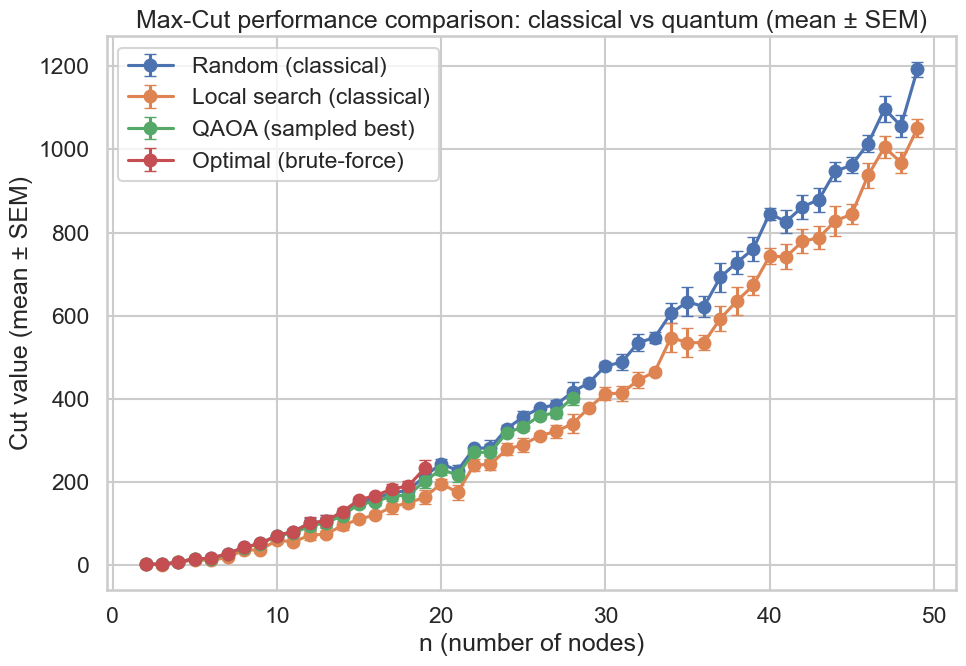

In [59]:
# Cell 6: cut value plots with error bars using precomputed std columns
def plot_cut_values(agg_df):
    plt.figure(figsize=(10, 7))

    def errplot(x, y, yerr, label, **kwargs):
        plt.errorbar(x, y, yerr=yerr, fmt='-o',
                     capsize=4, label=label, **kwargs)

    errplot(agg_df['n'], agg_df['rand_cut_mean'],
            agg_df['rand_cut_sem'], 'Random (classical)')
    errplot(agg_df['n'], agg_df['local_cut_mean'],
            agg_df['local_cut_sem'], 'Local search (classical)')
    errplot(agg_df['n'], agg_df['qaoa_best_cut_mean'],
            agg_df['qaoa_best_cut_sem'], 'QAOA (sampled best)')
    if 'opt_cut_mean' in agg_df.columns and agg_df['opt_cut_mean'].notnull().any():
        errplot(agg_df['n'], agg_df['opt_cut_mean'],
                agg_df['opt_cut_sem'], 'Optimal (brute-force)')

    plt.xlabel('n (number of nodes)')
    plt.ylabel('Cut value (mean ± SEM)')
    plt.title('Max-Cut performance comparison: classical vs quantum (mean ± SEM)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_cut_values(agg_df)

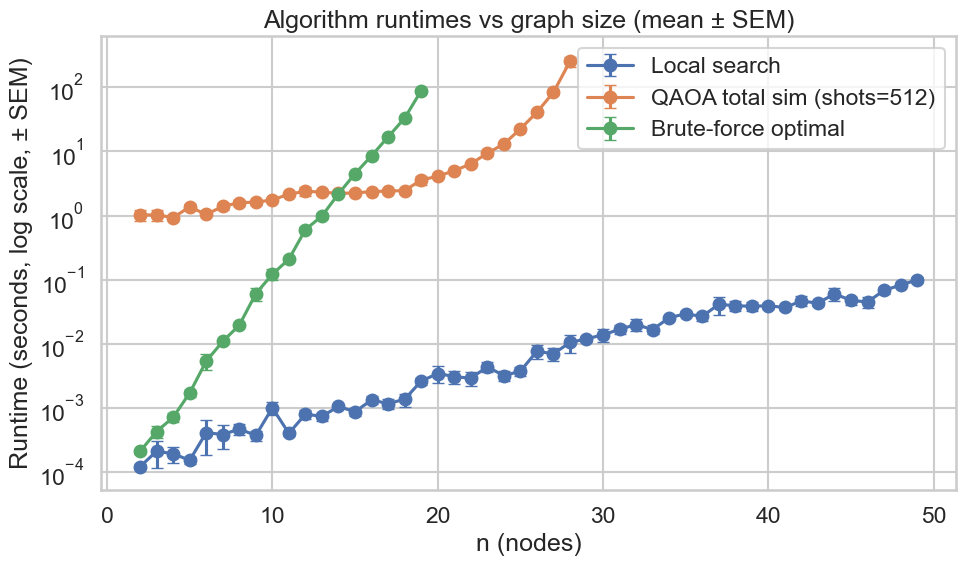

In [60]:
# Cell 7: runtime plots with error bars (log scale)
def plot_runtimes(agg_df):
    plt.figure(figsize=(10, 6))

    def errplot(x, ymean, yerr, label, **kwargs):
        plt.errorbar(x, ymean, yerr=yerr, fmt='-o',
                     capsize=4, label=label, **kwargs)

    errplot(agg_df['n'], agg_df['local_time_mean'],
            agg_df['local_time_sem'], 'Local search')
    errplot(agg_df['n'], agg_df['qaoa_total_time_mean'],
            agg_df['qaoa_total_time_sem'], f'QAOA total sim (shots={QAOA_SHOTS})')
    if 'opt_time_mean' in agg_df.columns and agg_df['opt_time_mean'].notnull().any():
        errplot(agg_df['n'], agg_df['opt_time_mean'],
                agg_df['opt_time_sem'], 'Brute-force optimal')

    plt.yscale('log')
    plt.xlabel('n (nodes)')
    plt.ylabel('Runtime (seconds, log scale, ± SEM)')
    plt.title('Algorithm runtimes vs graph size (mean ± SEM)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_runtimes(agg_df)

In [61]:
# Cell 8: save raw and aggregated results (optional)
df.to_csv('../data/maxcut_qaoa_raw_results.csv', index=False)
agg_df.to_csv('../data/maxcut_qaoa_aggregates.csv', index=False)
print("Saved CSVs: raw and aggregates.")

Saved CSVs: raw and aggregates.


In [ ]:
# ================================================================
# Hardware (IBM Runtime) test run for Max-Cut QAOA, n=8
# ================================================================
from qiskit_ibm_runtime import QiskitRuntimeService
from lib.graphlib import run_on_ibm_runtime, backend_info

# --- setup
service = QiskitRuntimeService()
available_backends = [b for b in service.backends() if b.configuration().n_qubits >= 8 and b.status().operational]
backend_name = sorted(available_backends, key=lambda b: b.status().pending_jobs)[0].name
print("Backend info:", backend_info(backend_name, service))

# --- build graph and QAOA circuit
g = GraphLib()
g.generate_random_graph(num_vertices=30, edge_prob=EDGE_PROB, weight_range=WEIGHT_RANGE)
gamma, beta, _, _ = g.optimize_qaoa1_classical(grid_res=21, refine=True)
qc = g.build_qaoa1_circuit(gamma, beta)
qc.measure_all()

# --- run on hardware via IBM Runtime
t0 = time.time()
res = run_on_ibm_runtime(qc, backend_name=backend_name, shots=QAOA_SHOTS, service=service)
t1 = time.time()

# --- timing info
print(f"\nWall-clock time (submit→done): {t1 - t0:.2f} sec")
if res["metadata"] is not None:
    print("Provider metadata keys:", list(res["metadata"][0].keys()))
else:
    print("No provider-side timing metadata available for this backend.")

# --- analyze counts
counts = res["counts"]
if counts:
    best_cut = g.cut_value_from_bitstring(max(counts, key=counts.get))
    print(f"Best observed cut value (from hardware sample): {best_cut}")
else:
    print("No counts returned — inspect res['raw_result'] for details.")

management.get:WARNING:2025-10-29 14:49:34,845: Loading default saved account


Backend info: {'backend_name': 'ibm_fez', 'num_qubits': 156, 'pending_jobs': 265, 'operational': True, 'avg_readout_error': 0.0}
